# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
!pip install torchinfo

In [ ]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output

sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 271068747.23it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39088639.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 218414963.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5825849.78it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Посмотрим на размеры датасетов

In [ ]:
print(
    f'Размер train датасета: {len(train_dataset)}\nРазмер vaidation датасета: {len(val_dataset)}'
)

Размер train датасета: 60000
Размер vaidation датасета: 10000


Визуализируйте несколько картинок с соответствующими метками из датасета.

Посмотрим на 5 случайных картинок

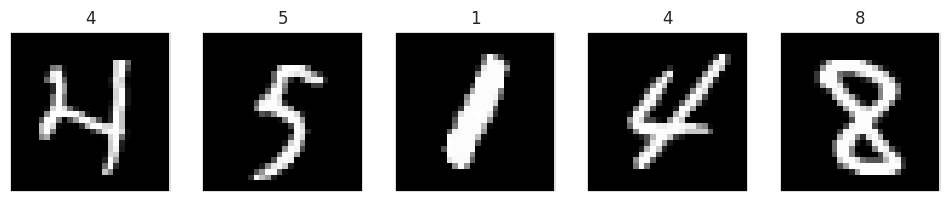

In [ ]:
plt.figure(figsize=(12, 12))

for cnt, i in enumerate(np.random.randint(0, len(train_dataset), 5)):
    image, label = train_dataset[i]
    plt.subplot(1, 5, cnt + 1)

    plt.imshow(image.permute((1, 2, 0)), cmap='gray')
    plt.title(classes[label])

    plt.xticks([])
    plt.yticks([])

Создайте генераторы батчей.

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

Создадим для начала максимально простую свёрточную сеть с 1 свёрточным и 1 линейным слоем

In [ ]:
cnn_list = []  # Список нейронных сетей отличающихся числом слоев

#1st layer, 1 1
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=13 * 13 * 16, out_features=10),
    ).to(device))

Проверим структуру сети

In [ ]:
summary(cnn_list[0], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─ReLU: 1-3                              [1, 16, 13, 13]           --
├─Flatten: 1-4                           [1, 2704]                 --
├─Linear: 1-5                            [1, 10]                   27,050
Total params: 27,210
Trainable params: 27,210
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.11
Estimated Total Size (MB): 0.20

У данной сети 27,210 параметров

Добавим 2й линейный слой

In [ ]:
#2nd layer 1 2
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=13 * 13 * 32, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[1], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 256]                  1,384,704
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 1,387,594
Trainable params: 1,387,594
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.55
Estimated Total Size (MB): 5.73

У данной сети 1,387,594 параметра

Создадим сеть с 2мя свёрточными и 1 линейным слоем

In [ ]:
#3rd layer 2 1
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=121 * 16, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[2], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 26, 26]            80
├─MaxPool2d: 1-2                         [1, 8, 13, 13]            --
├─ReLU: 1-3                              [1, 8, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           1,168
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─Flatten: 1-6                           [1, 1936]                 --
├─Linear: 1-7                            [1, 10]                   19,370
Total params: 20,618
Trainable params: 20,618
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

У данной сети 20,618 параметров

Создадим сеть с 2мя свёрточными и 2мя линейными слоями

In [ ]:
#4th layer 2 2
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=121 * 32, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[3], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─ReLU: 1-3                              [1, 16, 13, 13]           --
├─Conv2d: 1-4                            [1, 32, 11, 11]           4,640
├─ReLU: 1-5                              [1, 32, 11, 11]           --
├─Flatten: 1-6                           [1, 3872]                 --
├─Linear: 1-7                            [1, 256]                  991,488
├─ReLU: 1-8                              [1, 256]                  --
├─Linear: 1-9                            [1, 10]                   2,570
Total params: 998,858
Trainable params: 998,858
Non-trainable params: 0
Total mult-adds (M): 1.66
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 4.00
Estimated Total Size (MB): 4.12

У данной сети 998,858 параметров

Добавим дополнительный maxpooling после 2го свёрточного слоя

In [ ]:
#5th layer 2 2
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=25 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[4], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─ReLU: 1-3                              [1, 16, 13, 13]           --
├─Conv2d: 1-4                            [1, 32, 11, 11]           4,640
├─MaxPool2d: 1-5                         [1, 32, 5, 5]             --
├─ReLU: 1-6                              [1, 32, 5, 5]             --
├─Flatten: 1-7                           [1, 800]                  --
├─Linear: 1-8                            [1, 128]                  102,528
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 108,618
Trainable params: 108,618
Non-trainable params: 0
Total mult-adds (M): 0.77
Input size (MB): 0.00
Forward/backward pass s

У данной сети 108,618 параметров

Создадим сеть с 3мя свёрточными и 2мя линейными

In [ ]:
#6th layer 3 2
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=81 * 64, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[5], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─ReLU: 1-3                              [1, 16, 13, 13]           --
├─Conv2d: 1-4                            [1, 32, 11, 11]           4,640
├─ReLU: 1-5                              [1, 32, 11, 11]           --
├─Conv2d: 1-6                            [1, 64, 9, 9]             18,496
├─ReLU: 1-7                              [1, 64, 9, 9]             --
├─Flatten: 1-8                           [1, 5184]                 --
├─Linear: 1-9                            [1, 256]                  1,327,360
├─ReLU: 1-10                             [1, 256]                  --
├─Linear: 1-11                           [1, 10]                   2,570
Total params: 1,353,226
Trainable params: 1,353,226
Non-trainable p

У данной сети 1,353,226 параметров

Создадим сложную сеть. Сделаю предположения что из-за сложности данной сети она переобучится и будет демонстрировать плохие результаты на тестовой выборке

In [ ]:
#7th layer 4 4
cnn_list.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=64 * 64, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_list[6], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─ReLU: 1-2                              [1, 16, 26, 26]           --
├─Conv2d: 1-3                            [1, 32, 24, 24]           4,640
├─ReLU: 1-4                              [1, 32, 24, 24]           --
├─MaxPool2d: 1-5                         [1, 32, 12, 12]           --
├─Conv2d: 1-6                            [1, 32, 10, 10]           9,248
├─ReLU: 1-7                              [1, 32, 10, 10]           --
├─Conv2d: 1-8                            [1, 64, 8, 8]             18,496
├─ReLU: 1-9                              [1, 64, 8, 8]             --
├─Flatten: 1-10                          [1, 4096]                 --
├─Linear: 1-11                           [1, 512]                  2,097,664
├─ReLU: 1-12                             [1, 512]                  

У данной сети 2,163,690 параметров

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

Определим необходимые функции, используем функции семинара

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print("  training accuracy: \t\t\t{:.2f} %".format(
        history["acc"]["train"][-1] * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        history["acc"]["val"][-1] * 100))


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(X_batch, y_batch, model, criterion, current_loss,
                   current_acc):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(model,
          criterion,
          optimizer,
          train_batch_gen,
          val_batch_gen,
          num_epochs=40):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc)

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, train_loss, train_acc, len(train_batch_gen),
                       "train")

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(X_batch, y_batch, model,
                                                      criterion, val_loss,
                                                      val_acc)

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

Определим лосс и оптимайзер

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = [torch.optim.Adam(cnn_list[i].parameters()) for i in range(7)]
history_cnn = []

Обучим сети, в течении 40 эпох

In [ ]:
for i in range(7):
    history_cnn.append(
        train(
            cnn_list[i],
            criterion,
            optimizer[i],
            train_batch_gen,
            val_batch_gen,
            num_epochs=40,
        ))

Epoch 40 of 40 took 9.464 s
  training loss: 	0.001592
  validation loss: 	0.081847
  training accuracy: 			99.95 %
  validation accuracy: 			98.99 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["red", "orange", "yellow", "green", "blue", "purple", "pink"]
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(history["loss"]["val"][:epochs],
                    lw=1.5,
                    c=colors[i],
                    ls="--")
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(history["acc"]["train"][:epochs],
                    label=f"{name}",
                    lw=2,
                    c=colors[i])
        axs[1].plot(history["acc"]["val"][:epochs],
                    lw=1.5,
                    c=colors[i],
                    ls="--")
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

Отобразим Лосс и точность каждой сети

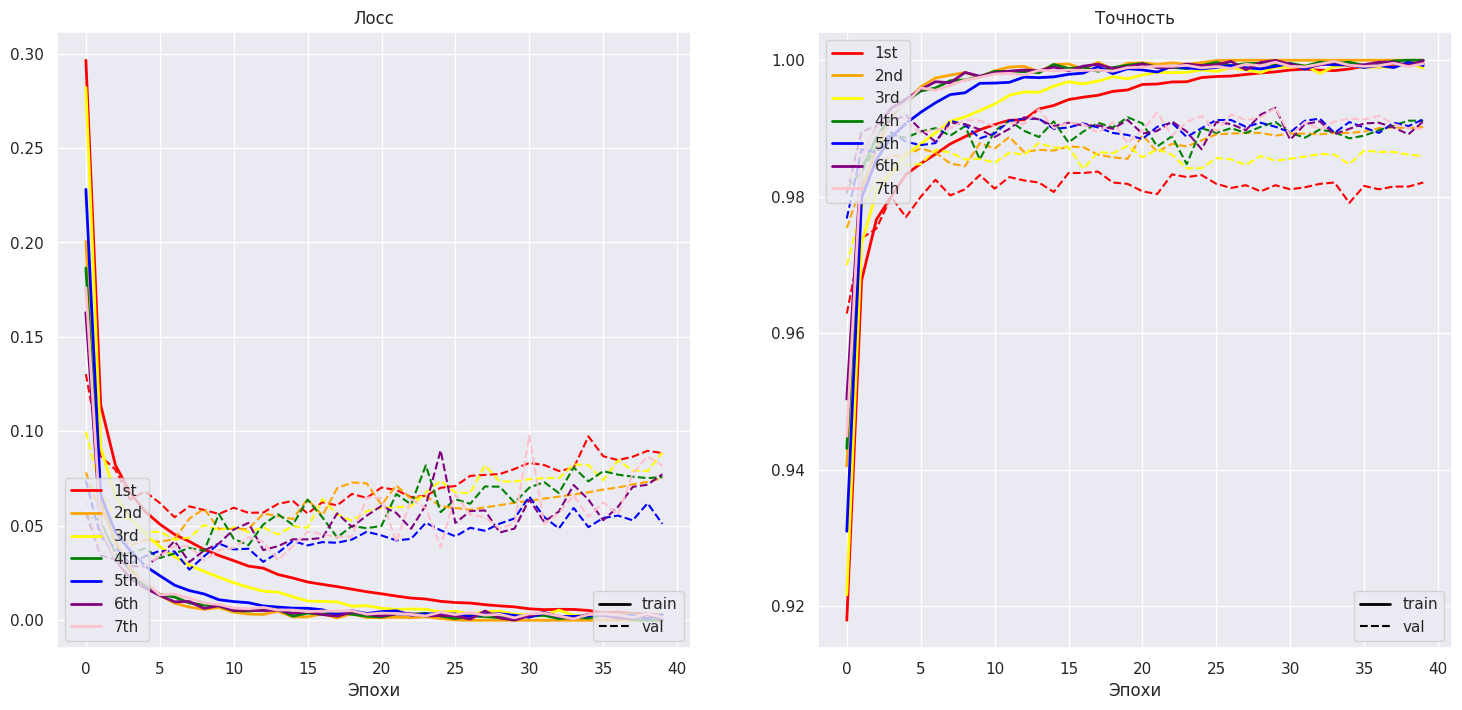

In [ ]:
plot_histories(history_cnn, ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th"])

Посмотрим ближе на процент точности каждой сети

In [ ]:
for i in range(7):
    print("  validation accuracy({}): \t\t\t{:.2f} %".format(
        i + 1, history_cnn[i]["acc"]["val"][-1] * 100))

  validation accuracy(1): 			98.21 %
  validation accuracy(2): 			99.02 %
  validation accuracy(3): 			98.60 %
  validation accuracy(4): 			99.11 %
  validation accuracy(5): 			99.13 %
  validation accuracy(6): 			99.10 %
  validation accuracy(7): 			98.99 %


Посмотрим на изменения точности в уже обученных сетях, чтобы лучше увидить разницу: отобразим только последние 30 эпох

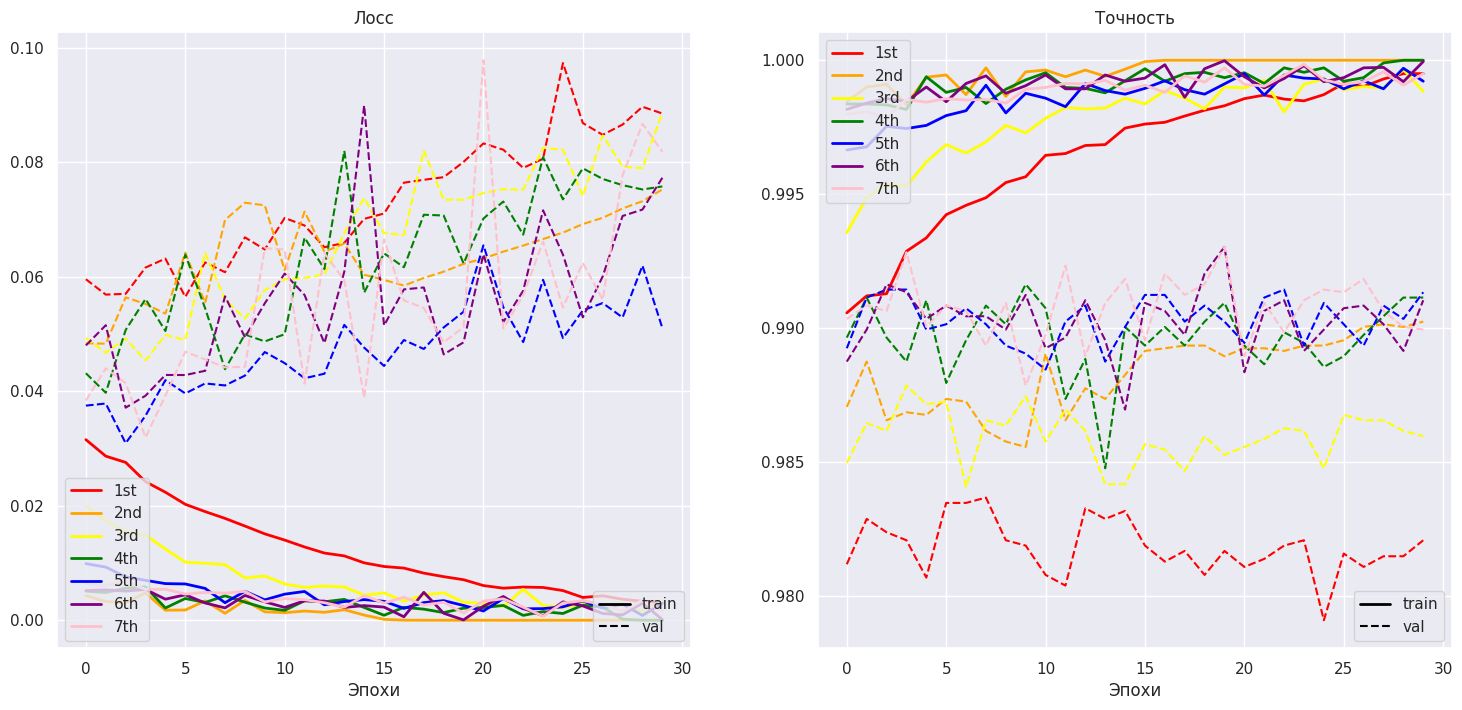

In [ ]:
import copy

history_copy = copy.deepcopy(history_cnn)
for i in range(7):
    history_copy[i]['loss']['val'] = history_copy[i]['loss']['val'][-30:]
    history_copy[i]['acc']['val'] = history_copy[i]['acc']['val'][-30:]
    history_copy[i]['loss']['train'] = history_copy[i]['loss']['train'][-30:]
    history_copy[i]['acc']['train'] = history_copy[i]['acc']['train'][-30:]

plot_histories(history_copy, ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th"])

Мы видим что почти все свёрточные нейросети демонстрируют точность свыше 98%(кроме первой сети, для которой мы не можем гарантировать такую точность), но также можем выделить 2 самые простые сети, состоящие не более чем из 3х слоёв. Они показывают медленне обучаются и демонстрируют меньший процент точности на валидационном датасете. <br>
Сети использующие от 2х свёрточных и 2х линейных слоёв показывают очень схожие результаты, больше 99% точности, при этом число параметров может различаться больше чем в 10 раз. Схожие результаты показывает и сеть с 3мя слоями, она медленнее достигает такой точности, и эта точность не так сильно колеблеться. Эту точность можно объяснить большим числом параметров - больше миллиона. 

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**<br>
Таким образом, если сеть имеет достатчное число слоёв, от 2х свёрточных и 2х линейных, то новые слои не будут давать большого прироста точности, при этом сеть с 1 свёрточным слоем может демонстрировать схожие результаты, имея достаточное число параметров. Также не подтвердилась гипотеза о том, что при слишком большом числе параметров, сеть переобучиться - за 40 эпох такого не наблюдалось, было лишь небольшое возрастание лосса на валидациоонных данных, общее для всех сетей, но снижения точности не наблюдалось

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [1]:
cnn_ker_size = []  # Список свёрточных сетей по размеру ядра

В качестве лучшего варианта сети возьмём сеть с 2мя свёрточными и 2мя линейными слоями, из прошлого пункта ясно, что нет большой разницы до тех пор пока в сети достаточно слоёв. Такой вариант лучший с точки зрения вариации размера ядер, мы сможем проследить зависимость, если она существует.

Изменим размер первого свёрточного окна до 5

In [ ]:
#2nd net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=25 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[0], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─MaxPool2d: 1-2                         [1, 16, 12, 12]           --
├─ReLU: 1-3                              [1, 16, 12, 12]           --
├─Conv2d: 1-4                            [1, 32, 10, 10]           4,640
├─MaxPool2d: 1-5                         [1, 32, 5, 5]             --
├─ReLU: 1-6                              [1, 32, 5, 5]             --
├─Flatten: 1-7                           [1, 800]                  --
├─Linear: 1-8                            [1, 128]                  102,528
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 108,874
Trainable params: 108,874
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.00
Forward/backward pass s

Изменим размер второго свёрточного окна до 5

In [ ]:
#3rd net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=16 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[1], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─ReLU: 1-3                              [1, 16, 13, 13]           --
├─Conv2d: 1-4                            [1, 32, 9, 9]             12,832
├─MaxPool2d: 1-5                         [1, 32, 4, 4]             --
├─ReLU: 1-6                              [1, 32, 4, 4]             --
├─Flatten: 1-7                           [1, 512]                  --
├─Linear: 1-8                            [1, 128]                  65,664
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 79,946
Trainable params: 79,946
Non-trainable params: 0
Total mult-adds (M): 1.21
Input size (MB): 0.00
Forward/backward pass siz

Размер обоих ядер = 5



In [ ]:
#4th net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=16 * 32, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[2], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─MaxPool2d: 1-2                         [1, 16, 12, 12]           --
├─ReLU: 1-3                              [1, 16, 12, 12]           --
├─Conv2d: 1-4                            [1, 32, 8, 8]             12,832
├─MaxPool2d: 1-5                         [1, 32, 4, 4]             --
├─ReLU: 1-6                              [1, 32, 4, 4]             --
├─Flatten: 1-7                           [1, 512]                  --
├─Linear: 1-8                            [1, 64]                   32,832
├─ReLU: 1-9                              [1, 64]                   --
├─Linear: 1-10                           [1, 10]                   650
Total params: 46,730
Trainable params: 46,730
Non-trainable params: 0
Total mult-adds (M): 1.09
Input size (MB): 0.00
Forward/backward pass size 

Изменим размер окна maxpooling'a, добавим padding во 2-м слое

In [ ]:
#5th net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.MaxPool2d(3),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=64 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[3], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─MaxPool2d: 1-2                         [1, 16, 8, 8]             --
├─ReLU: 1-3                              [1, 16, 8, 8]             --
├─Conv2d: 1-4                            [1, 32, 8, 8]             12,832
├─ReLU: 1-5                              [1, 32, 8, 8]             --
├─Flatten: 1-6                           [1, 2048]                 --
├─Linear: 1-7                            [1, 128]                  262,272
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 10]                   1,290
Total params: 276,810
Trainable params: 276,810
Non-trainable params: 0
Total mult-adds (M): 1.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.11
Estimated Total Size (MB): 1.20

Размер первого ядра свёртки = 7

In [ ]:
#6th net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=144 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[4], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           800
├─MaxPool2d: 1-2                         [1, 16, 12, 12]           --
├─ReLU: 1-3                              [1, 16, 12, 12]           --
├─Conv2d: 1-4                            [1, 32, 12, 12]           12,832
├─ReLU: 1-5                              [1, 32, 12, 12]           --
├─Flatten: 1-6                           [1, 4608]                 --
├─Linear: 1-7                            [1, 128]                  589,952
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 10]                   1,290
Total params: 604,874
Trainable params: 604,874
Non-trainable params: 0
Total mult-adds (M): 2.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 2.42
Estimated Total Size (MB): 2.53

Размеры ядер 9 и 7 соответственно

In [ ]:
#7th net
cnn_ker_size.append(
    nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9, padding=2),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=100 * 32, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10),
    ).to(device))

In [ ]:
summary(cnn_ker_size[5], input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           1,312
├─MaxPool2d: 1-2                         [1, 16, 12, 12]           --
├─ReLU: 1-3                              [1, 16, 12, 12]           --
├─Conv2d: 1-4                            [1, 32, 10, 10]           25,120
├─ReLU: 1-5                              [1, 32, 10, 10]           --
├─Flatten: 1-6                           [1, 3200]                 --
├─Linear: 1-7                            [1, 128]                  409,728
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 10]                   1,290
Total params: 437,450
Trainable params: 437,450
Non-trainable params: 0
Total mult-adds (M): 3.68
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 1.75
Estimated Total Size (MB): 1.

In [ ]:
optimizer2 = [torch.optim.Adam(cnn_ker_size[i].parameters()) for i in range(6)]

history2_cnn = []

Обучим сети в течении 40 эпох

In [ ]:
for i in range(6):
    history2_cnn.append(
        train(
            cnn_ker_size[i],
            criterion,
            optimizer2[i],
            train_batch_gen,
            val_batch_gen,
            num_epochs=40,
        ))

Epoch 40 of 40 took 8.611 s
  training loss: 	0.004025
  validation loss: 	0.068111
  training accuracy: 			99.91 %
  validation accuracy: 			99.25 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

In [53]:
len(history2_cnn[-6:])

6

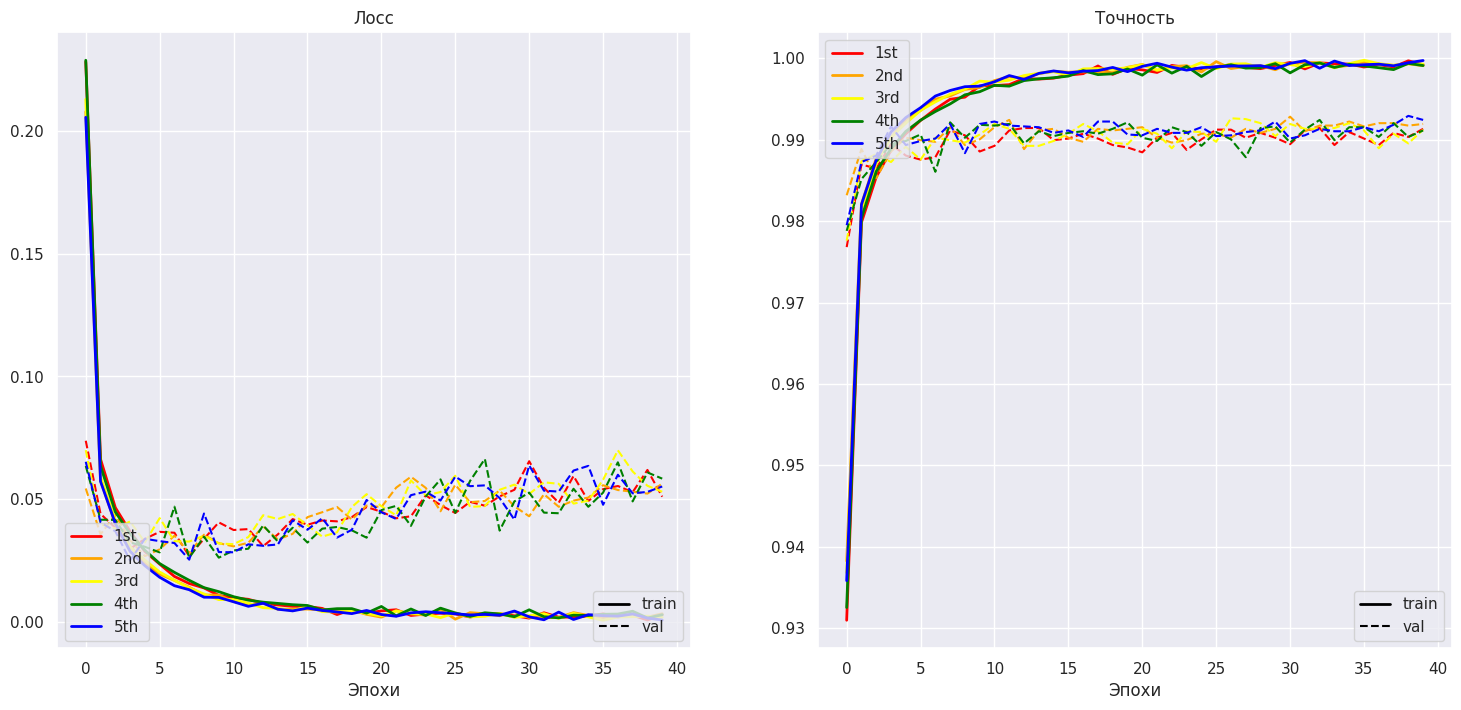

In [54]:
plot_histories([history_cnn[4]] + history2_cnn[-6:],
               ["1st", "2nd", "3rd", "4th", "5th"])

Посмотрим на изменения точности в уже обученных сетях: отобразим только вторую половину обучения(последние 30 эпох)

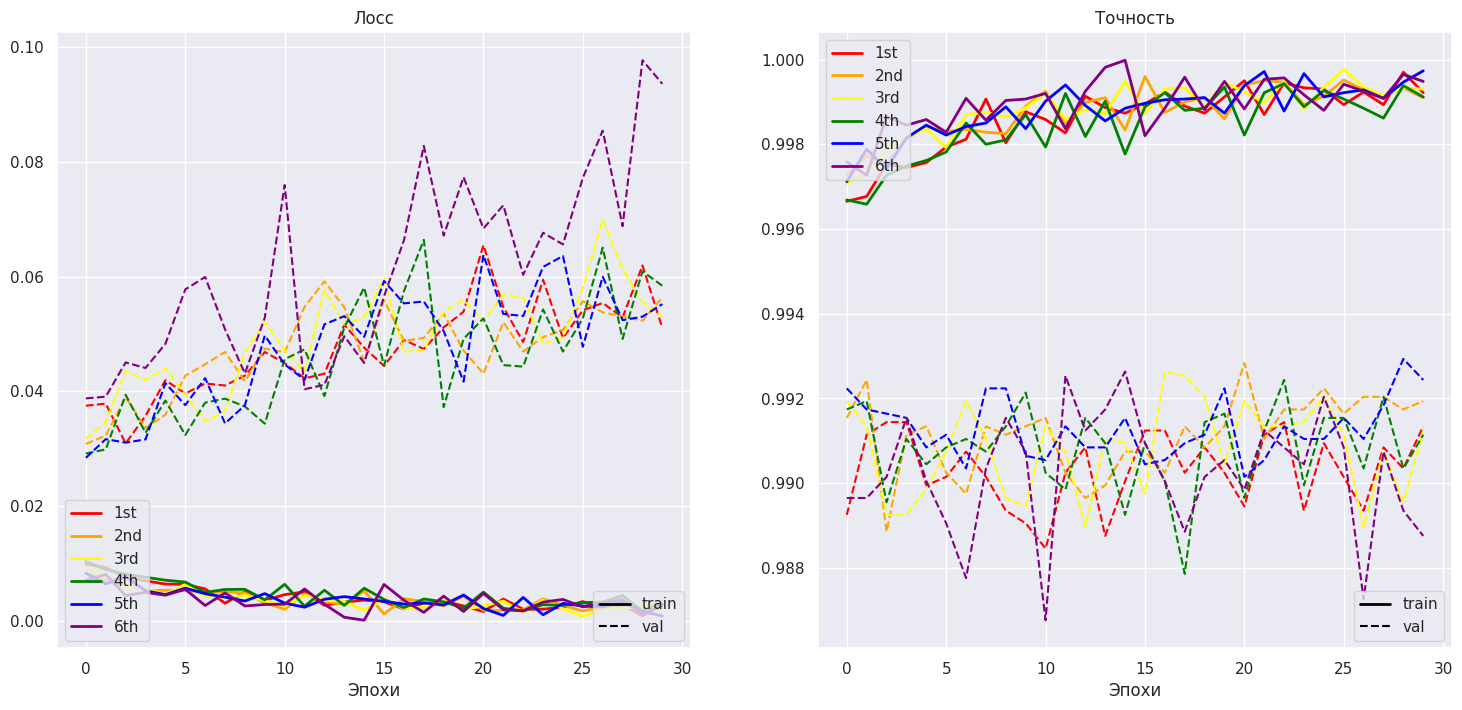

In [55]:
history2_copy = copy.deepcopy([history_cnn[4]] + history2_cnn[-6:])
for i in range(7):
    history2_copy[i]['loss']['val'] = history2_copy[i]['loss']['val'][-30:]
    history2_copy[i]['acc']['val'] = history2_copy[i]['acc']['val'][-30:]
    history2_copy[i]['loss']['train'] = history2_copy[i]['loss']['train'][-30:]
    history2_copy[i]['acc']['train'] = history2_copy[i]['acc']['train'][-30:]

plot_histories(history2_copy, ["1st", "2nd", "3rd", "4th", "5th", "6th"])

Мы видим, что все сети демонстрируют точность около 99% в независимости от размера ядра, при этом можно выделить сеть с самым большим размером ядра(сеть номер 6). Она самая нестабильная: больше всех подвержена колебаниям точности на тестовом датасете, и имеет самый большой лосс. При лучшей сетью, судя по всему являетсся сеть номер 2, с первым ядром размера 5 и вторым размера 3, потому что в течении последних 10 эпох она показывала стабильную точность, при этом более высокую, по сравнению с остальными сетями.

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?


**Вывод по эксперименту 2:** <br>
Можно сделать вывод, что как и в эксперименте 1, размер ядер не оказывает сильного вляиния ни на качество ни на время обучения, но при этом зависимость всё таки есть. Сеть с большим размером ядра менее стабильна. А лучшим, в данном случае вариантом, является сеть с небольшими размерами ядер, и чтобы размер первого был больше второго.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

В качестве лучшей модели возьмем 2ю сеть с размером ядра первого слоя равным 5 и второго слоя равным 3

In [84]:
model = copy.copy(cnn_ker_size[0])  # Лучшая модель - 2я сеть 
model.eval()

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [178]:
error_im = 10 * [0]  # Число ошибок в каждой категории
error_pr = 10 * [0]  # Число ошибок в каждом предсказании
cat_cnt = 10 * [0]  # Число каритнок в каждой категории
pred_cnt = 10 * [0]  # Число ошибок в каждом предсказании
wrong_guesses = []  # Ошибочно-определённые картинки
avg_wrong_prob = 0  # Уверенность сети когда она неправа
avg_right_prob = 0  # Уверенность сети когда она права

In [180]:
from torch.utils.data import DataLoader, ConcatDataset

# Объеденим датасеты
comb_dataset = ConcatDataset([train_dataset, val_dataset])
comb_loader = DataLoader(comb_dataset, batch_size=1, shuffle=False)

for image, label in comb_loader:
    with torch.no_grad():
        logits = model(image.to(device))[0].cpu()
    avg_right_prob += torch.softmax(logits, dim=0).max()
    pred = logits.max(0)[1].detach().cpu().numpy()
    cat_cnt[label.cpu().numpy()[0]] += 1
    pred_cnt[pred] += 1
    if str(label.cpu().numpy()[0]) != str(pred):
        avg_right_prob -= torch.softmax(logits, dim=0).max()
        avg_wrong_prob += torch.softmax(logits, dim=0).max()
        error_im[label.cpu().numpy()[0]] += 1
        error_pr[pred] += 1
        wrong_guesses.append([image, label])

for i in range(10):
    error_im[i] /= cat_cnt[i]
    error_pr[i] /= pred_cnt[i]
avg_wrong_prob /= len(wrong_guesses)
avg_right_prob /= (len(comb_dataset) - len(wrong_guesses))

Построим график показывающий процент ошибочных ответов, в определении каждой цифры, и график, показывающий какой процент неправильности предикта, т.е долю случаев, когда данный предикт не совпадает с меткой класса

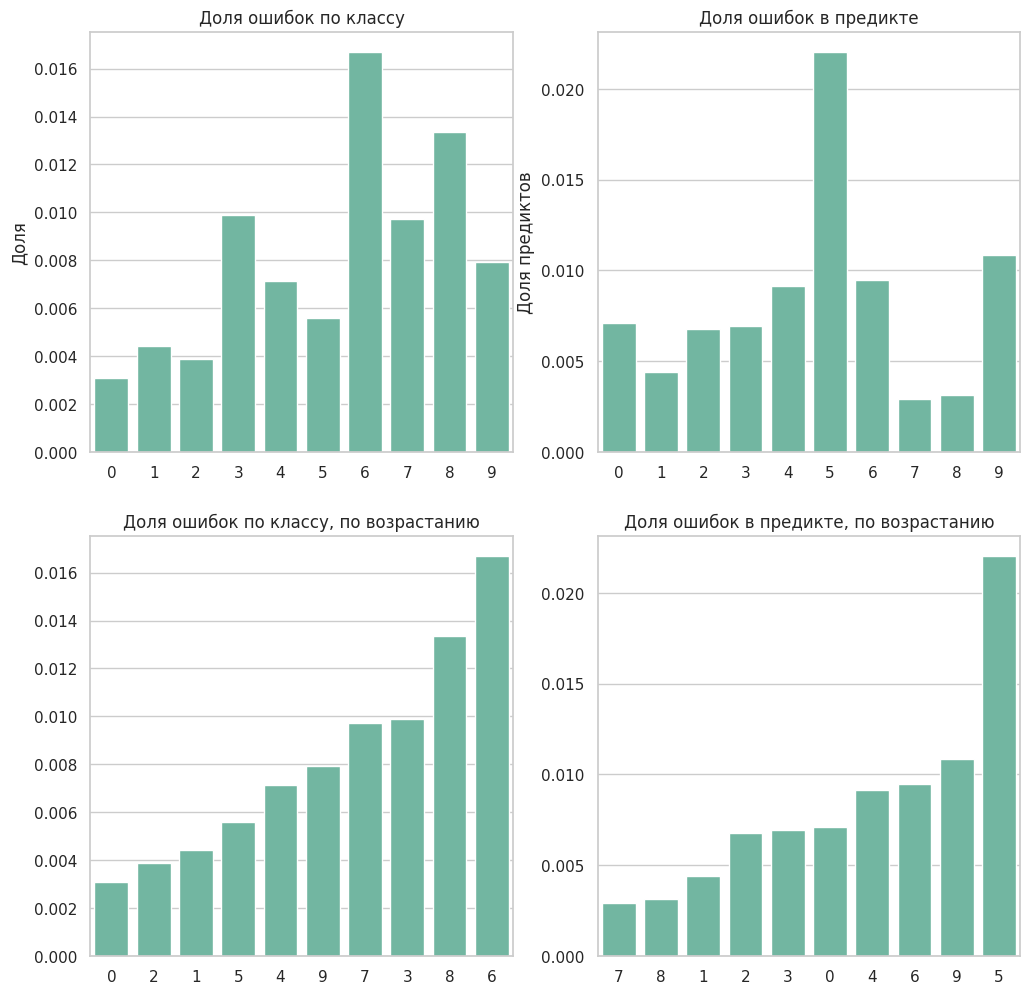

In [181]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.set_style("whitegrid")
sns.barplot(x=classes, y=error_im, errorbar=None)
plt.title('Доля ошибок по классу')
plt.ylabel('Доля')

plt.subplot(2, 2, 2)
sns.set_style("whitegrid")
sns.barplot(x=classes, y=error_pr, errorbar=None)
plt.title('Доля ошибок в предикте')
plt.ylabel('Доля предиктов')

plt.subplot(2, 2, 3)
a = np.argsort(error_im)
sns.set_style("whitegrid")
sns.barplot(x=np.take_along_axis(np.array(classes), a, axis=0),
            y=np.take_along_axis(np.array(error_im), a, axis=0),
            errorbar=None)
plt.title('Доля ошибок по классу, по возрастанию')
plt.ylabel('')

plt.subplot(2, 2, 4)
b = np.argsort(error_pr)
sns.set_style("whitegrid")
sns.barplot(x=np.take_along_axis(np.array(classes), b, axis=0),
            y=np.take_along_axis(np.array(error_pr), b, axis=0),
            errorbar=None)
plt.title('Доля ошибок в предикте, по возрастанию')

Видим, что точность неравномерна, в том смысле, что есть классы с высокой точностью, а есть с маленькой. Но при этом есть промежуточные значений точности, кторые равномерно заполняют этот отрезок.<br>
Если же смотреть на ошибочные прогнозы модели, то видно, что модель зачастую видит цифру 5 там, где её нет. Это можно объяснить тем, что в цифре 5 есть много паттернов, характерных, в том числе и для других цифр.<br>


Посмотрим на уверенность сети в правильности своего предикта в двух случаях:

In [187]:
print(
    f'Средняя уверенность модели на неправильных ответах: {avg_wrong_prob*100:.2f}%\nСредняя уверенность модели на правильных ответах: {avg_right_prob*100:.2f}%'
)

Средняя уверенность модели на неправильных ответах: 91.71%
Средняя уверенность модели на правильных ответах: 99.87%


Видим, что модель в среднем на 8% меньше уверена в картинках, в которых она допускает ошибку

Посмотрим на неправильно распознанные цифры, отобразим вероятности по каждой из категорий

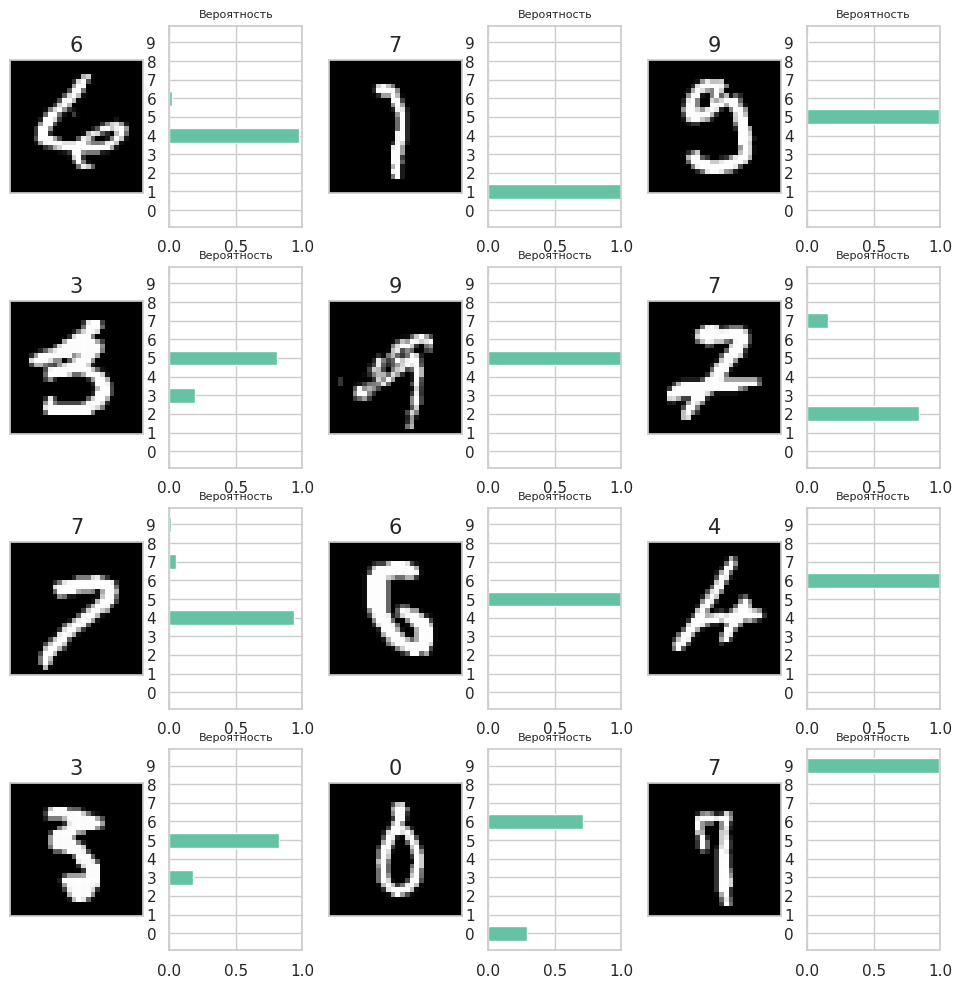

In [65]:
import random

random.shuffle(wrong_guesses)
cnt = 1
plt.figure(figsize=(12, 12))
for i in range(12):
    with sns.axes_style("whitegrid"):
        image, label = wrong_guesses[i]

        plt.subplot(4, 6, cnt)
        cnt += 1
        plt.imshow(image[0].permute((1, 2, 0)), cmap='gray')
        plt.title(classes[label], fontsize=15)
        plt.xticks([])
        plt.yticks([])

        # Выключим градиенты на момент вычислений
        with torch.no_grad():
            logits = model(image.to(device))[0].cpu()

        # Применяем softmax по оси классов
        prob = torch.softmax(logits, dim=0)

        plt.subplot(4, 6, cnt)

        cnt += 1
        plt.barh(classes, prob)
        plt.xlim([0, 1])
        plt.title("Вероятность", fontsize=8)

**Ответ:** <br>


Видим, что в целом наша модель достаточно уверенная, в том смысле, что зачастую не рассматривает другие варианты, даже если они правильные.<br>
Если же посмотреть на картинки, то станет понятно, что это по большей части сложные картинки, например на это картинке совершенно ничего не понятно:


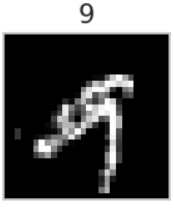

в которых запросто может ошибиться даже человек. Но если у людей могут быть разногласия, то непонятно, что в таком случае принимать за истину. Поэтому процент точности вблизи 100% не играет такой большой роли. <br>
Однако видно, что среди ошибок встречаются достаточно простые картинки как например

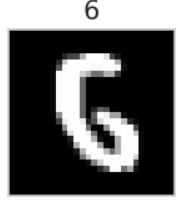

которые модель распознала неправильно. На примере данной картинки мы видим как модель в непонятной ситуации отдаёт предпочтение 5-ке. в тех случаях когда своершенно понятно что это не 5

**Вывод по всей задаче:** <br>
Можно сделать вывод, что наличие в датасете нетривиальных картинок не только портит точность из-за того что они сложны для определения, но и из-за того что они дают ложное представление о цифре к которой относятся. Как и следовало ожидать, на правильных ответах модель демонстрирует большую уверенность, но ожидалась меньшая уверенность в случае неправильных ответов. Также некоторые цифрры даются модели сложнее чем остальные.
<br>
В целом мы получили точность свыше 99%, что является хорошим результатом

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [16]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

Подключим google drive

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Заимпортируем необходимые файлы

In [3]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 29.29 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


Определим нужные функции

In [6]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [7]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (Path(content_image).stem + "_" + Path(style_image).stem +
                      ".jpg")
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [37]:
content_path = "/content/drive/MyDrive/mipt-stats/Content"
style_path = "/content/drive/MyDrive/mipt-stats/Style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/
!ls data/style-images

1.jpg  2.jpg  3.jpg  4.jpg  5.jpg


Запустим Neural Style Transfer на парах контент-стиль

In [38]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=624735027200.0000, content_loss=      0.0000, style loss=624731040000.0000, tv loss=3965439.0000
L-BFGS | iteration: 100, total loss=12212072448.0000, content_loss=554137792.9688, style loss=11645631562.5000, tv loss=12302880.0000
L-BFGS | iteration: 200, total loss=3063207168.0000, content_loss=548163183.5938, style loss=2502003750.0000, tv loss=13040464.0000
L-BFGS | iteration: 300, total loss=1664923136.0000, content_loss=527532226.5625, style loss=1124370468.7500, tv loss=13020372.0000
L-BFGS | iteration: 400, total loss=1215034496.0000, content_loss=505885742.1875, style loss=696498808.5938, tv loss=12650032.0000
L-BFGS | iteration: 500, total loss=1007070080.0000, content_loss=492575927.7344, style loss=502292343.7500, tv loss=12201762.0000
L-BFGS | iteration: 600, total loss=896800832.0000, content_loss=482714843.7500, style loss=402343593.7500, tv loss=11742388.0000
L-BFGS | iteration: 700, total los

Отобразим данные в двух частях(чтобы они поместились в окне вывода)

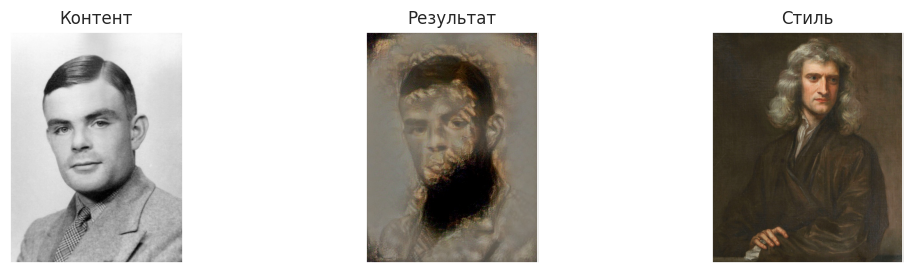

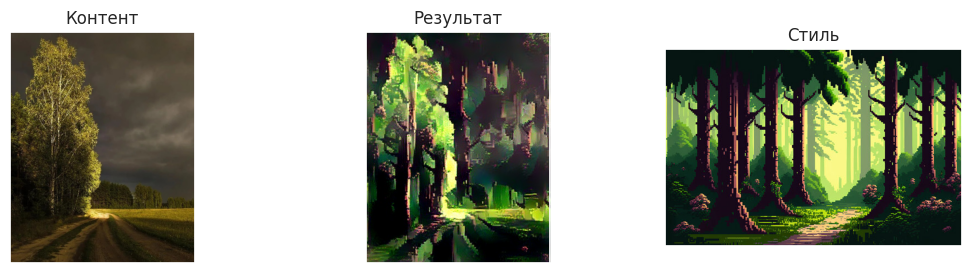

In [43]:
# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/mipt-stats

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images[:2], style_images[:2], result_paths[:2]
):
    visualize_style_transfer(content_image, style_image, results_path)

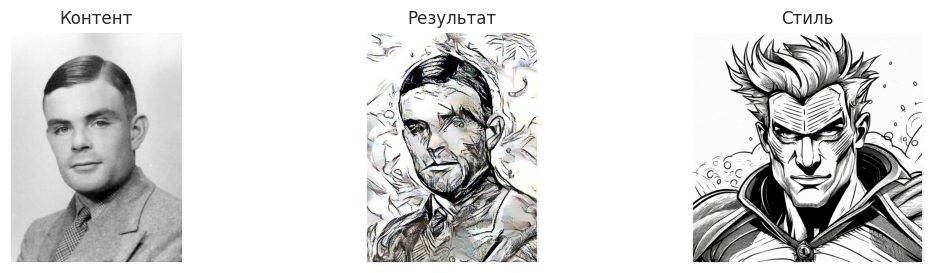

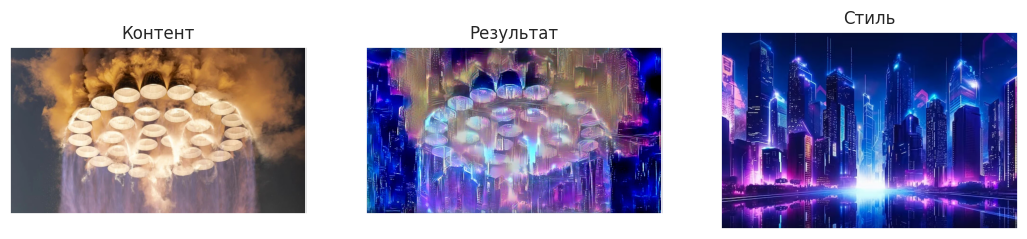

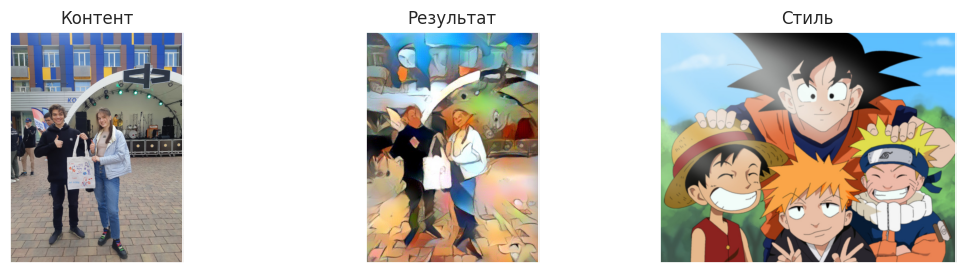

In [44]:
# Визуализируем
for content_image, style_image, results_path in zip(
    content_images[2:], style_images[2:], result_paths[2:]
):
    visualize_style_transfer(content_image, style_image, results_path)

Мы получили достаточно интересные результаты. Тьюринг в стиле портрета Ньютона - единственное неудавшееся изображение. Скорее всего это произошло из-за того что в картинке-контенте всего 1 канал, она ведь чёрно-белая, в то время как в стиле 3 канала, также, если в качестве картинки-стиля взять чб изображение, такой проблемы не возникает. <br>
Также заметно что модель плохо справляется с фоном и однородными участками изображения - она стремиться их разнообразить и добавляет ненужные детали(небо на 2,4 картинке, фон на 3)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [45]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.3 MB/s eta 0:00:00


In [46]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

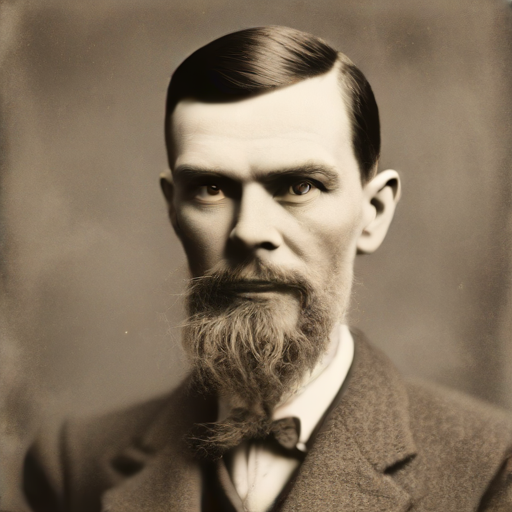

In [90]:
prompt = "Alan Turing with very very long beard portrait"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1,
             guidance_scale=0.0).images[0]
image

По какой-то причиние диффузионная сеть не может нарисовать очень длинную бороду

  0%|          | 0/1 [00:00<?, ?it/s]

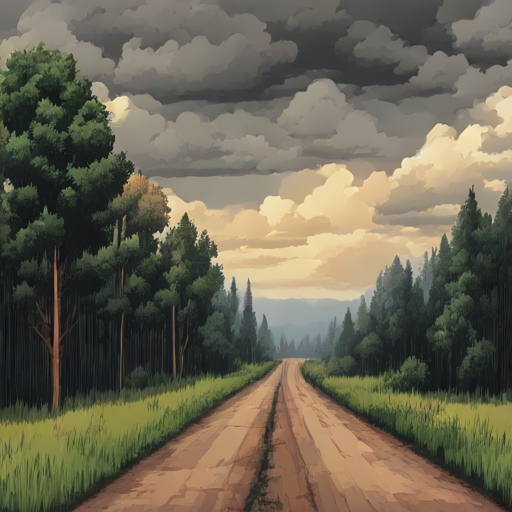

In [124]:
prompt = "country road,  field on the right and stormy weather in a forest pixelart"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1,
             guidance_scale=0.0).images[0]
image

Также у нейросети не получается рисовать в стиле "пиксель-арт"

  0%|          | 0/1 [00:00<?, ?it/s]

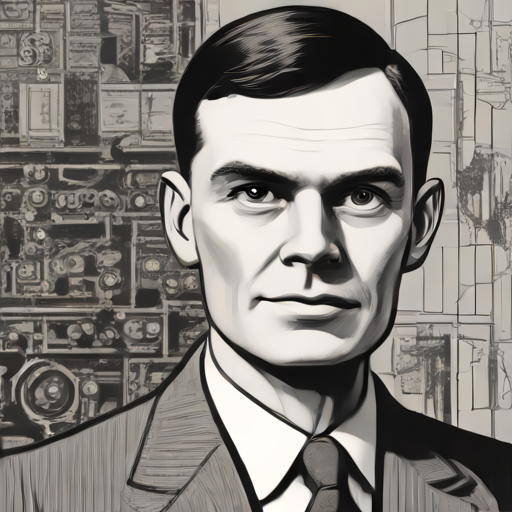

In [138]:
prompt = "Alan Turing comic book portrait black and white"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1,
             guidance_scale=0.0).images[0]
image

Не хватает характерных для комиксов штрихов, в остальном - отлинчая картинка

  0%|          | 0/1 [00:00<?, ?it/s]

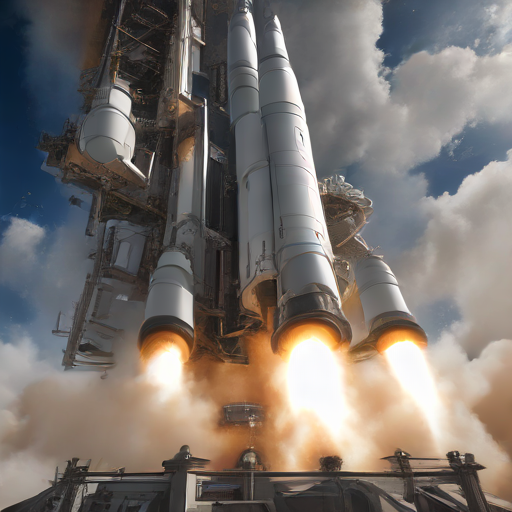

In [174]:
prompt = "rocket engines firing, highly detailed"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1,
             guidance_scale=0.0).images[0]
image

Интересно то, что у модели не получается нарисовать ракетный двигатель, она без труда рисует сами ракеты, но добиться от сети традиционного ракетного двигателя у меня так и не получилось. Скорее это всего связано с отсутствиям понимания у модели и связанность ракетного двигателя с ракетой. Модель просто не может себе представить двигатель как не часть ракеты, поэтому и рисует такие странные колонны, которые судя по всему являются ракетами

  0%|          | 0/2 [00:00<?, ?it/s]

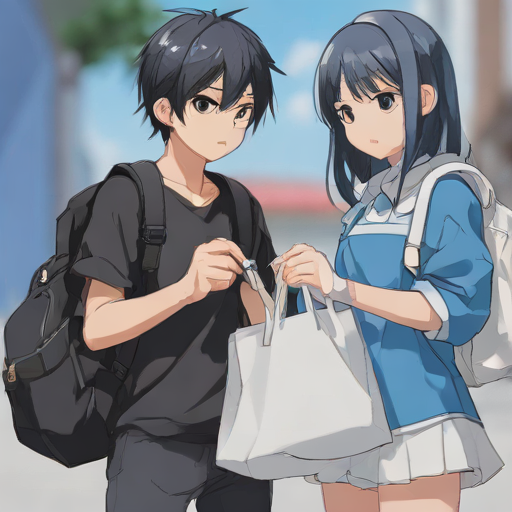

In [194]:
prompt = "boy in black ang girl in blue holding white bag together, anime highly detailed"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=2,
             guidance_scale=0.0).images[0]
image

Последняя картинка получилась лучше всего

**Вывод:**
<br>
Мы объединили стили и контексты в 5 картинок, а затем пронаблюдали получившиеся рещультаты. Модель плохо справляется с небом и фоном, в которые добавляет ненужные детали. Затем мы попытались получить такие же результаты с помощью диффузионной сети. Диффузионная сеть плохо рисует вещи, для которых необходимо понимание их устройства. Однако это всё искусство и кто мы такие чтобы говорить что картина нарисована неправильно, в понимании нейросети эта картина правильная, а красота, как известно, субъективна!